# Phase 1: Data Collection & Preprocessing
## Wikipedia Article Generator with GraphRAG

**Objective**: Collect and preprocess a small Wikipedia dataset (<1GB) for building our knowledge graph

**What we'll do in this notebook:**
1. Set up environment and install required libraries
2. Download Wikipedia articles using Wikipedia API (targeted topics)
3. Parse and clean article content
4. Extract entities and relationships
5. Create vector embeddings
6. Prepare data for knowledge graph construction

**Dataset Strategy**: Instead of downloading the full 20GB Wikipedia dump, we'll:
- Use Wikipedia API to fetch ~1000-2000 articles on specific topics
- Focus on interconnected topics (e.g., Science, Technology, History)
- Keep total size under 1GB

---

## Step 1: Install Required Libraries

First, let's install all the dependencies we need. Run this cell once at the beginning.

In [1]:
# Install required packages
# Run this cell once, then restart kernel if needed

!pip install wikipedia-api
!pip install mwparserfromhell
!pip install spacy
!pip install sentence-transformers
!pip install pandas
!pip install numpy
!pip install tqdm
!pip install beautifulsoup4
!pip install networkx
!pip install matplotlib
!pip install seaborn

# Download spaCy language model
!python -m spacy download en_core_web_sm

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wikipedia-api: filename=wikipedia_api-0.8.1-py3-none-any.whl size=15542 sha256=f17a890e95059d4959299193dd8910f4420b86e2f9c5407cd5584ca46b79b6c3
  Stored in directory: d:\pip_cache\wheels\e2\47\f0\0afcbc01ff2bb0f35c593aae7ddebbeef350e46dfddeca47d8
Successfully built wikipedia-api
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -----

## Step 2: Import Libraries

Import all necessary libraries for data collection, processing, and analysis.

In [2]:
# Core libraries
import os
import json
import pickle
import time
from pathlib import Path
from datetime import datetime
from collections import defaultdict

# Data processing
import pandas as pd
import numpy as np

# Wikipedia API
import wikipediaapi

# Text processing
import mwparserfromhell
from bs4 import BeautifulSoup
import re

# NLP
import spacy
from sentence_transformers import SentenceTransformer

# Graph & visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm.auto import tqdm

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")


✓ All libraries imported successfully!
Working directory: d:\Projects\agent-wiki-graphrag\notebooks


## Step 3: Setup Directory Structure

Create necessary directories for storing our data.

In [3]:
# Define project paths
PROJECT_ROOT = Path(r"d:\Projects\agent-wiki-graphrag")
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
EMBEDDINGS_DIR = DATA_DIR / "embeddings"
KG_DIR = DATA_DIR / "knowledge_graph"

# Create directories if they don't exist
for directory in [RAW_DIR, PROCESSED_DIR, EMBEDDINGS_DIR, KG_DIR]:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created/verified: {directory}")

# Define output file paths
ARTICLES_FILE = RAW_DIR / "wikipedia_articles.json"
ENTITIES_FILE = PROCESSED_DIR / "entities.json"
RELATIONS_FILE = PROCESSED_DIR / "relations.json"
EMBEDDINGS_FILE = EMBEDDINGS_DIR / "article_embeddings.pkl"
METADATA_FILE = PROCESSED_DIR / "metadata.json"

print(f"\n✓ Directory structure ready!")
print(f"Data will be saved to: {DATA_DIR}")

✓ Created/verified: d:\Projects\agent-wiki-graphrag\data\raw
✓ Created/verified: d:\Projects\agent-wiki-graphrag\data\processed
✓ Created/verified: d:\Projects\agent-wiki-graphrag\data\embeddings
✓ Created/verified: d:\Projects\agent-wiki-graphrag\data\knowledge_graph

✓ Directory structure ready!
Data will be saved to: d:\Projects\agent-wiki-graphrag\data


## Step 4: Define Target Topics

Define the topics we want to collect. We'll focus on interconnected domains to create a rich knowledge graph while staying under 1GB.

**Strategy**: 
- Start with seed topics (e.g., "Artificial Intelligence", "Machine Learning")
- Follow links to related articles (up to 2 hops)
- Target ~1500-2000 articles total
- Estimated size: 500MB-800MB

In [4]:
# Define seed topics across different domains
SEED_TOPICS = {
    "Technology": [
        "Artificial intelligence",
        "Machine learning",
        "Natural language processing",
        "Computer vision",
        "Deep learning",
        "Neural network",
        "Transformer (machine learning model)",
        "Large language model"
    ],
    "Science": [
        "Quantum computing",
        "Quantum mechanics",
        "Theory of relativity",
        "Particle physics",
        "String theory"
    ],
    "Computing": [
        "Algorithm",
        "Data structure",
        "Python (programming language)",
        "Software engineering",
        "Cloud computing"
    ],
    "Mathematics": [
        "Linear algebra",
        "Calculus",
        "Graph theory",
        "Statistics",
        "Probability theory"
    ]
}

# Flatten seed topics
seed_topics_list = [topic for topics in SEED_TOPICS.values() for topic in topics]

print(f"Total seed topics: {len(seed_topics_list)}")
print(f"\nSeed topics by domain:")
for domain, topics in SEED_TOPICS.items():
    print(f"  {domain}: {len(topics)} topics")

# Configuration
MAX_ARTICLES = 2000  # Maximum number of articles to collect
MAX_HOPS = 2  # How many link hops to follow
MAX_SIZE_MB = 900  # Stop if we exceed this size

Total seed topics: 23

Seed topics by domain:
  Technology: 8 topics
  Science: 5 topics
  Computing: 5 topics
  Mathematics: 5 topics


## Step 5: Initialize Wikipedia API Client

Set up the Wikipedia API client to fetch articles.

In [5]:
# Initialize Wikipedia API
wiki_wiki = wikipediaapi.Wikipedia(
    user_agent='WikipediaArticleGenerator/1.0 (Educational Project)',
    language='en',
    extract_format=wikipediaapi.ExtractFormat.WIKI
)

print("✓ Wikipedia API client initialized")
print(f"Language: English")
print(f"Format: Wiki markup")

✓ Wikipedia API client initialized
Language: English
Format: Wiki markup


## Step 6: Article Collection Functions

Create functions to fetch articles and follow links.

In [6]:
class WikipediaCollector:
    """Collect Wikipedia articles with BFS link following"""
    
    def __init__(self, wiki_client, max_articles=2000, max_size_mb=900):
        self.wiki = wiki_client
        self.max_articles = max_articles
        self.max_size_mb = max_size_mb
        self.collected_articles = {}
        self.visited_titles = set()
        self.current_size_mb = 0
        
    def get_article(self, title):
        """Fetch a single article"""
        try:
            page = self.wiki.page(title)
            if not page.exists():
                return None
            
            # Extract article data
            article_data = {
                'title': page.title,
                'url': page.fullurl,
                'text': page.text,
                'summary': page.summary,
                'categories': [cat for cat in page.categories.keys()],
                'links': [link for link in list(page.links.keys())[:50]],  # Limit links
                'sections': [section.title for section in page.sections],
                'length': len(page.text),
                'timestamp': datetime.now().isoformat()
            }
            
            # Estimate size
            size_mb = len(json.dumps(article_data)) / (1024 * 1024)
            
            return article_data, size_mb
            
        except Exception as e:
            print(f"Error fetching {title}: {str(e)}")
            return None
    
    def collect_articles(self, seed_topics, max_hops=2):
        """Collect articles using BFS from seed topics"""
        
        # Initialize queue with seed topics
        queue = [(topic, 0) for topic in seed_topics]  # (title, hop_level)
        
        with tqdm(total=self.max_articles, desc="Collecting articles") as pbar:
            while queue and len(self.collected_articles) < self.max_articles:
                
                # Check size limit
                if self.current_size_mb >= self.max_size_mb:
                    print(f"\n⚠ Size limit reached: {self.current_size_mb:.2f} MB")
                    break
                
                title, hop_level = queue.pop(0)
                
                # Skip if already visited
                if title in self.visited_titles:
                    continue
                
                self.visited_titles.add(title)
                
                # Fetch article
                result = self.get_article(title)
                if result is None:
                    continue
                
                article_data, size_mb = result
                
                # Store article
                self.collected_articles[title] = article_data
                self.current_size_mb += size_mb
                
                # Update progress
                pbar.update(1)
                pbar.set_postfix({
                    'size_mb': f'{self.current_size_mb:.1f}',
                    'hop': hop_level
                })
                
                # Add linked articles to queue (if within hop limit)
                if hop_level < max_hops:
                    for link in article_data['links'][:10]:  # Limit links per article
                        if link not in self.visited_titles:
                            queue.append((link, hop_level + 1))
                
                # Rate limiting
                time.sleep(0.1)
        
        print(f"\n✓ Collection complete!")
        print(f"  Articles collected: {len(self.collected_articles)}")
        print(f"  Total size: {self.current_size_mb:.2f} MB")
        
        return self.collected_articles

# Initialize collector
collector = WikipediaCollector(wiki_wiki, MAX_ARTICLES, MAX_SIZE_MB)
print("✓ Article collector initialized")

✓ Article collector initialized


## Step 7: Collect Wikipedia Articles

Now let's collect the articles! This will take ~10-20 minutes depending on your internet connection.

**Note**: If you want to test faster, reduce `MAX_ARTICLES` to 100-200 first.

In [7]:
# Start collection
print(f"Starting collection at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Target: {MAX_ARTICLES} articles, max {MAX_SIZE_MB} MB\n")

articles = collector.collect_articles(seed_topics_list, max_hops=MAX_HOPS)

# Save to file
with open(ARTICLES_FILE, 'w', encoding='utf-8') as f:
    json.dump(articles, f, ensure_ascii=False, indent=2)

print(f"\n✓ Articles saved to: {ARTICLES_FILE}")
print(f"File size: {ARTICLES_FILE.stat().st_size / (1024*1024):.2f} MB")

Starting collection at 2026-01-02 17:56:31
Target: 2000 articles, max 900 MB




✓ Collection complete!
  Articles collected: 1337
  Total size: 29.29 MB

✓ Articles saved to: d:\Projects\agent-wiki-graphrag\data\raw\wikipedia_articles.json
File size: 29.80 MB


## Step 8: Explore Collected Data

Let's examine what we've collected.

In [8]:
# Basic statistics
print(f"Total articles collected: {len(articles)}")
print(f"\nArticle statistics:")

# Convert to DataFrame for analysis
articles_df = pd.DataFrame([
    {
        'title': title,
        'length': data['length'],
        'num_categories': len(data['categories']),
        'num_links': len(data['links']),
        'num_sections': len(data['sections'])
    }
    for title, data in articles.items()
])

print(articles_df.describe())

# Show sample articles
print(f"\n\nSample articles:")
print(articles_df[['title', 'length', 'num_sections']].head(10))

Total articles collected: 1337

Article statistics:
              length  num_categories    num_links  num_sections
count    1337.000000     1337.000000  1337.000000   1337.000000
mean    19082.154076       14.486163    46.347794      7.263276
std     25422.058496       12.165463     9.366669      3.866148
min         0.000000        1.000000     5.000000      0.000000
25%      3866.000000        7.000000    50.000000      4.000000
50%      9842.000000       11.000000    50.000000      7.000000
75%     24874.000000       18.000000    50.000000     10.000000
max    379606.000000      112.000000    50.000000     21.000000


Sample articles:
                                  title  length  num_sections
0               Artificial intelligence   89303            13
1                      Machine learning   59060            18
2           Natural language processing   32211             8
3                       Computer vision   38759            11
4                         Deep learning   5

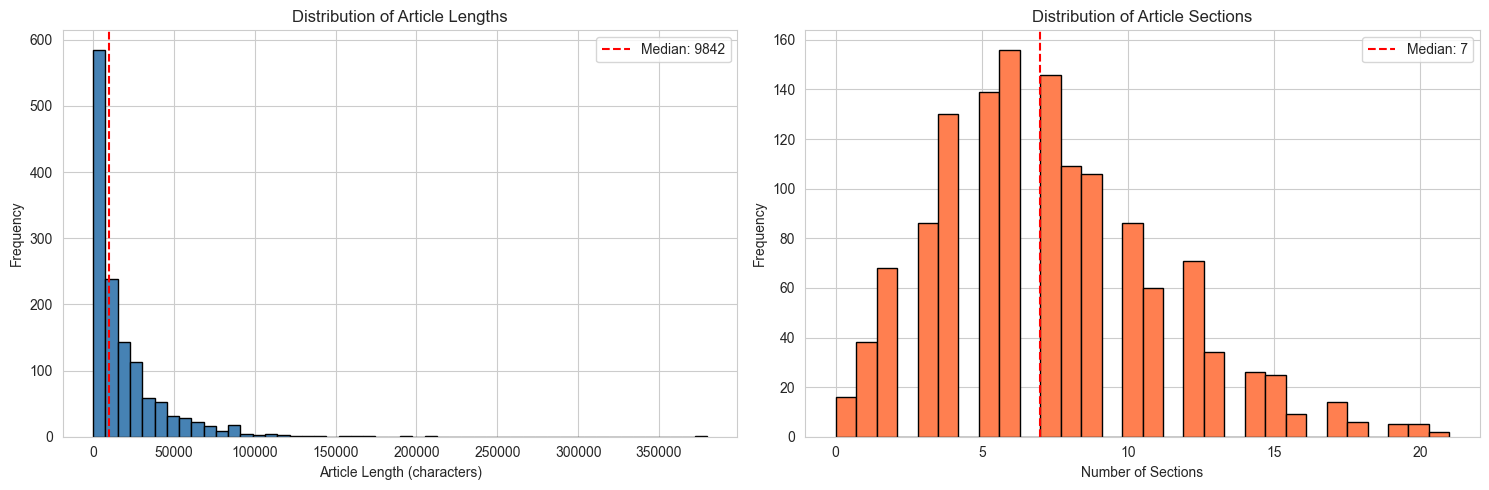

In [9]:
# Visualize article length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Article length histogram
axes[0].hist(articles_df['length'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Article Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Article Lengths')
axes[0].axvline(articles_df['length'].median(), color='red', linestyle='--', 
                label=f'Median: {articles_df["length"].median():.0f}')
axes[0].legend()

# Number of sections
axes[1].hist(articles_df['num_sections'], bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Number of Sections')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Article Sections')
axes[1].axvline(articles_df['num_sections'].median(), color='red', linestyle='--',
                label=f'Median: {articles_df["num_sections"].median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## Step 9: Text Preprocessing

Clean and preprocess the article text for entity extraction.

In [10]:
def clean_wikipedia_text(text):
    """Clean Wikipedia text markup"""
    # Remove citations [1], [2], etc.
    text = re.sub(r'\[\d+\]', '', text)
    
    # Remove multiple newlines
    text = re.sub(r'\n+', '\n', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Clean all articles
print("Cleaning article text...")
for title, data in tqdm(articles.items(), desc="Cleaning"):
    data['text_clean'] = clean_wikipedia_text(data['text'])
    data['summary_clean'] = clean_wikipedia_text(data['summary'])

print("✓ Text cleaning complete")

Cleaning article text...


Cleaning:   0%|          | 0/1337 [00:00<?, ?it/s]

✓ Text cleaning complete


## Step 10: Entity Extraction with spaCy

Extract named entities (people, organizations, locations, etc.) from articles.

In [11]:
# Load spaCy model
print("Loading spaCy model...")
nlp = spacy.load("en_core_web_sm")
print("✓ spaCy model loaded")

# Process articles and extract entities
all_entities = {}
entity_types = defaultdict(int)

print("\nExtracting entities from articles...")
for title, data in tqdm(list(articles.items())[:100], desc="Processing"):  # Start with 100 for speed
    # Process text (use summary for speed, or text_clean for completeness)
    doc = nlp(data['summary_clean'][:10000])  # Limit to first 10k chars
    
    # Extract entities
    entities = []
    for ent in doc.ents:
        entities.append({
            'text': ent.text,
            'label': ent.label_,
            'start': ent.start_char,
            'end': ent.end_char
        })
        entity_types[ent.label_] += 1
    
    all_entities[title] = entities
    data['entities'] = entities

print(f"\n✓ Entity extraction complete")
print(f"Articles processed: {len(all_entities)}")
print(f"Total entity mentions: {sum(len(e) for e in all_entities.values())}")
print(f"\nEntity types found:")
for ent_type, count in sorted(entity_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  {ent_type}: {count}")

Loading spaCy model...
✓ spaCy model loaded

Extracting entities from articles...


Processing:   0%|          | 0/100 [00:00<?, ?it/s]


✓ Entity extraction complete
Articles processed: 100
Total entity mentions: 1266

Entity types found:
  ORG: 343
  CARDINAL: 256
  DATE: 226
  PERSON: 145
  GPE: 126
  ORDINAL: 40
  QUANTITY: 36
  NORP: 29
  WORK_OF_ART: 17
  PRODUCT: 14
  LOC: 8
  PERCENT: 7
  FAC: 6
  MONEY: 5
  EVENT: 3
  LANGUAGE: 3
  TIME: 1
  LAW: 1


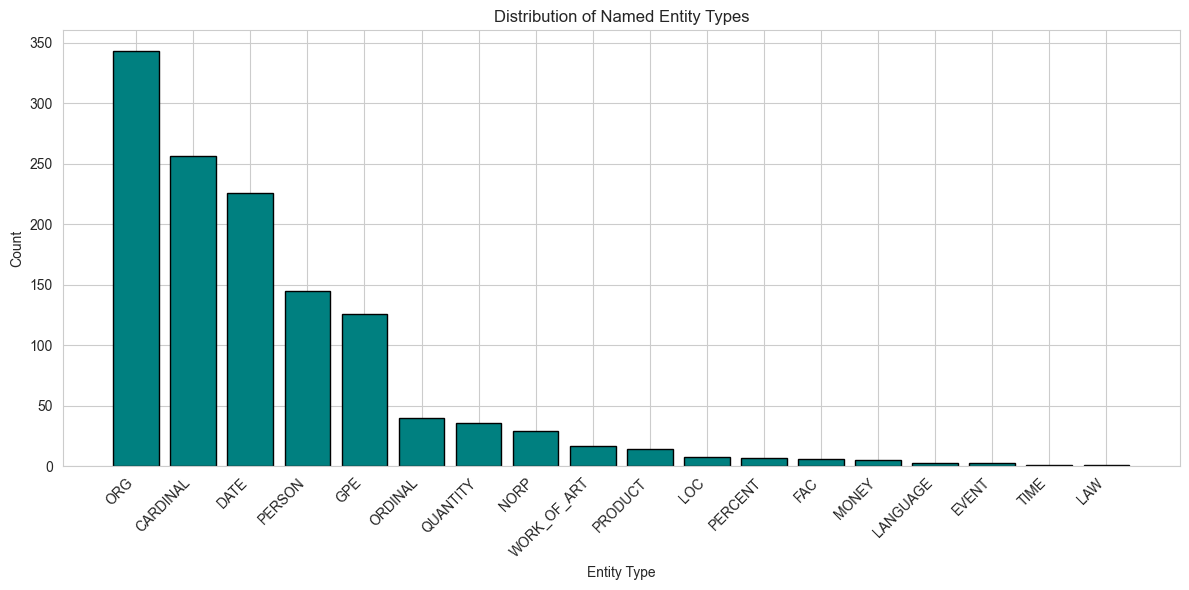


Example entities from 'Artificial intelligence':
  AI                             -> GPE
  Google Search                  -> ORG
  YouTube                        -> ORG
  Amazon                         -> ORG
  Netflix                        -> GPE
  Google                         -> ORG
  Alexa                          -> ORG
  Waymo                          -> WORK_OF_ART
  AI                             -> GPE
  AI                             -> GPE


In [12]:
# Visualize entity types
plt.figure(figsize=(12, 6))
entity_df = pd.DataFrame(list(entity_types.items()), columns=['Entity Type', 'Count'])
entity_df = entity_df.sort_values('Count', ascending=False)

plt.bar(entity_df['Entity Type'], entity_df['Count'], color='teal', edgecolor='black')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.title('Distribution of Named Entity Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show example entities
example_article = list(all_entities.keys())[0]
print(f"\nExample entities from '{example_article}':")
for ent in all_entities[example_article][:10]:
    print(f"  {ent['text']:30s} -> {ent['label']}")

## Step 11: Create Vector Embeddings

Generate semantic embeddings for all articles using sentence transformers.

## Step 11: Create Vector Embeddings

Generate embeddings for semantic search using sentence-transformers.

In [13]:
# Load sentence transformer model
print("Loading embedding model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ Embedding model loaded")
print(f"Model: all-MiniLM-L6-v2 (384 dimensions)")

# Create embeddings for article summaries
print("\nGenerating embeddings...")
article_embeddings = {}

for title, data in tqdm(articles.items(), desc="Embedding articles"):
    # Embed the summary (faster) or full text
    text_to_embed = data['summary_clean']
    embedding = embedding_model.encode(text_to_embed)
    article_embeddings[title] = embedding.tolist()

print(f"✓ Generated embeddings for {len(article_embeddings)} articles")
print(f"Embedding dimension: {len(list(article_embeddings.values())[0])}")

# Save embeddings
with open(EMBEDDINGS_FILE, 'wb') as f:
    pickle.dump(article_embeddings, f)
    
print(f"✓ Embeddings saved to: {EMBEDDINGS_FILE}")

Loading embedding model...
✓ Embedding model loaded
Model: all-MiniLM-L6-v2 (384 dimensions)

Generating embeddings...


Embedding articles:   0%|          | 0/1337 [00:00<?, ?it/s]

✓ Generated embeddings for 1337 articles
Embedding dimension: 384
✓ Embeddings saved to: d:\Projects\agent-wiki-graphrag\data\embeddings\article_embeddings.pkl


## Step 12: Build Initial Knowledge Graph Structure

Create a graph representation of articles and their relationships.

In [14]:
# Build graph using NetworkX (will migrate to Neo4j later)
print("Building knowledge graph...")
G = nx.DiGraph()

# Add article nodes
for title, data in tqdm(articles.items(), desc="Adding nodes"):
    G.add_node(title, 
               node_type='article',
               length=data['length'],
               num_sections=len(data['sections']),
               categories=data['categories'][:5])  # Limit categories

# Add link edges
edge_count = 0
for title, data in tqdm(articles.items(), desc="Adding edges"):
    for link in data['links']:
        if link in articles:  # Only link to articles in our collection
            G.add_edge(title, link, relationship='links_to')
            edge_count += 1

print(f"\n✓ Knowledge graph created")
print(f"  Nodes (articles): {G.number_of_nodes()}")
print(f"  Edges (links): {G.number_of_edges()}")
print(f"  Average degree: {edge_count / G.number_of_nodes():.2f}")

# Graph statistics
print(f"\n  Density: {nx.density(G):.4f}")
if nx.is_weakly_connected(G):
    print(f"  Graph is connected")
else:
    components = list(nx.weakly_connected_components(G))
    print(f"  Number of components: {len(components)}")
    print(f"  Largest component size: {len(max(components, key=len))}")

Building knowledge graph...


Adding nodes:   0%|          | 0/1337 [00:00<?, ?it/s]

Adding edges:   0%|          | 0/1337 [00:00<?, ?it/s]


✓ Knowledge graph created
  Nodes (articles): 1337
  Edges (links): 11091
  Average degree: 8.30

  Density: 0.0062
  Graph is connected


Creating graph visualization...


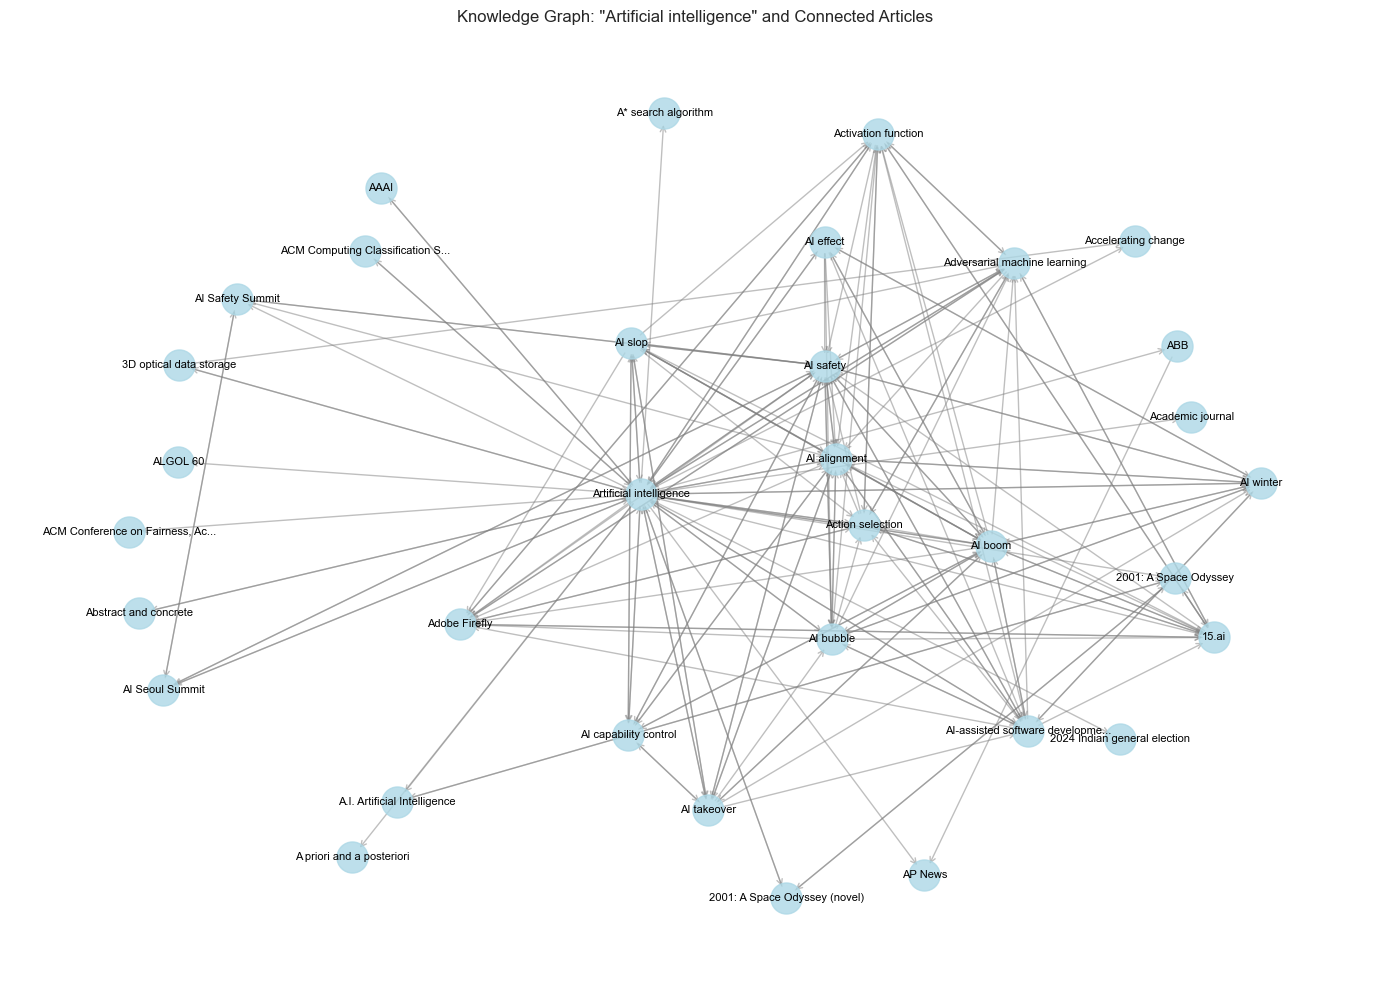

✓ Visualized subgraph with 34 nodes


In [15]:
# Visualize graph structure (sample)
print("Creating graph visualization...")

# Get a subgraph for visualization (full graph would be too dense)
seed_article = seed_topics_list[0]
if seed_article in G:
    # Get ego graph (article + neighbors)
    subgraph = nx.ego_graph(G, seed_article, radius=1)
    
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(subgraph, k=2, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, 
                          node_color='lightblue',
                          node_size=500,
                          alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos,
                          edge_color='gray',
                          alpha=0.5,
                          arrows=True,
                          arrowsize=10,
                          arrowstyle='->')
    
    # Draw labels (truncate long titles)
    labels = {node: node[:30] + '...' if len(node) > 30 else node 
              for node in subgraph.nodes()}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)
    
    plt.title(f'Knowledge Graph: "{seed_article}" and Connected Articles')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Visualized subgraph with {subgraph.number_of_nodes()} nodes")
else:
    print(f"Seed article '{seed_article}' not found in graph")

## Step 13: Save Processed Data

Save all processed data for use in subsequent notebooks.

In [17]:
# Save updated articles with entities
with open(ARTICLES_FILE, 'w', encoding='utf-8') as f:
    json.dump(articles, f, ensure_ascii=False, indent=2)
print(f"✓ Updated articles saved: {ARTICLES_FILE}")

# Save entities separately
with open(ENTITIES_FILE, 'w', encoding='utf-8') as f:
    json.dump(all_entities, f, ensure_ascii=False, indent=2)
print(f"✓ Entities saved: {ENTITIES_FILE}")

# Save graph (using pickle directly as write_gpickle is deprecated)
graph_file = KG_DIR / "article_graph.pkl"
with open(graph_file, 'wb') as f:
    pickle.dump(G, f)
print(f"✓ Graph saved: {graph_file}")

# Save metadata
metadata = {
    'collection_date': datetime.now().isoformat(),
    'total_articles': len(articles),
    'total_entities': sum(len(e) for e in all_entities.values()),
    'graph_nodes': G.number_of_nodes(),
    'graph_edges': G.number_of_edges(),
    'seed_topics': seed_topics_list,
    'max_hops': MAX_HOPS,
    'file_size_mb': ARTICLES_FILE.stat().st_size / (1024*1024)
}

with open(METADATA_FILE, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved: {METADATA_FILE}")

print(f"\n{'='*60}")
print(f"Phase 1 Complete! 🎉")
print(f"{'='*60}")
print(f"\nSummary:")
print(f"  Articles collected: {metadata['total_articles']}")
print(f"  Entities extracted: {metadata['total_entities']}")
print(f"  Graph nodes: {metadata['graph_nodes']}")
print(f"  Graph edges: {metadata['graph_edges']}")
print(f"  Total data size: {metadata['file_size_mb']:.2f} MB")
print(f"\nData saved to: {DATA_DIR}")
print(f"\nNext: Open notebook 02_graphrag_engine.ipynb to build the GraphRAG system!")

✓ Updated articles saved: d:\Projects\agent-wiki-graphrag\data\raw\wikipedia_articles.json
✓ Entities saved: d:\Projects\agent-wiki-graphrag\data\processed\entities.json
✓ Graph saved: d:\Projects\agent-wiki-graphrag\data\knowledge_graph\article_graph.pkl
✓ Metadata saved: d:\Projects\agent-wiki-graphrag\data\processed\metadata.json

Phase 1 Complete! 🎉

Summary:
  Articles collected: 1337
  Entities extracted: 1266
  Graph nodes: 1337
  Graph edges: 11091
  Total data size: 51.96 MB

Data saved to: d:\Projects\agent-wiki-graphrag\data

Next: Open notebook 02_graphrag_engine.ipynb to build the GraphRAG system!
